In [ ]:
#|hide
#|skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#|default_exp data.transforms

In [ ]:
#|export
from __future__ import annotations
from fastai.torch_basics import *
from fastai.data.core import *
from fastai.data.load import *
from fastai.data.external import *

from sklearn.model_selection import train_test_split

import posixpath

In [ ]:
#|hide
from nbdev.showdoc import *

# Helper functions for processing data and basic transforms

> Functions for getting, splitting, and labeling data, as well as generic transforms

## Get, split, and label

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

(#2) [Path('/home/hiromi/.fastai/data/mnist_tiny/train/7'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/3')]

In [ ]:
#|export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
#|export
def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `folders` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png', recurse=False)
t7 = get_files(path/'train'/'7', extensions='.png', recurse=False)
t  = get_files(path/'train', extensions='.png', recurse=True)
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg', recurse=False)),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, folders='train')))
t

(#709) [Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7769.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7334.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7388.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/8562.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7610.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/8283.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/904.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/9886.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/9429.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/8805.png')...]

In [ ]:
#|hide
test_eq(len(get_files(path/'train'/'3', recurse=False)),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders=['train', 'test'])),729)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders='train')),709)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders='training')),0)

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as CamelCase verbs ending in `er` to create these functions. `FileGetter` is a simple example of such a function creator.

In [ ]:
#|export
def FileGetter(suf='', extensions=None, recurse=True, folders=None):
    "Create `get_files` partial function that searches path suffix `suf`, only in `folders`, if specified, and passes along args"
    def _inner(o, extensions=extensions, recurse=recurse, folders=folders):
        return get_files(o/suf, extensions, recurse, folders)
    return _inner

In [ ]:
fpng = FileGetter(extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path/'train'/'7')))
test_eq(len(t), len(fpng(path/'train', recurse=True)))
fpng_r = FileGetter(extensions='.png', recurse=True)
test_eq(len(t), len(fpng_r(path/'train')))

In [ ]:
#|export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#|export
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, folders='train')))

In [ ]:
#|export
def ImageGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial that searches suffix `suf` and passes along `kwargs`, only in `folders`, if specified"
    def _inner(o, recurse=recurse, folders=folders): return get_image_files(o/suf, recurse, folders)
    return _inner

Same as `FileGetter`, but for image extensions.

In [ ]:
test_eq(len(get_files(path/'train', extensions='.png', recurse=True, folders='3')),
        len(ImageGetter(   'train',                    recurse=True, folders='3')(path)))

In [ ]:
#|export
def get_text_files(path, recurse=True, folders=None):
    "Get text files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=['.txt'], recurse=recurse, folders=folders)

In [ ]:
#|export
class ItemGetter(ItemTransform):
    "Creates a proper transform that applies `itemgetter(i)` (even on a tuple)"
    _retain = False
    def __init__(self, i): self.i = i
    def encodes(self, x): return x[self.i]

In [ ]:
test_eq(ItemGetter(1)((1,2,3)),  2)
test_eq(ItemGetter(1)(L(1,2,3)), 2)
test_eq(ItemGetter(1)([1,2,3]),  2)
test_eq(ItemGetter(1)(np.array([1,2,3])),  2)

In [ ]:
#|export
class AttrGetter(ItemTransform):
    "Creates a proper transform that applies `attrgetter(nm)` (even on a tuple)"
    _retain = False
    def __init__(self, nm, default=None): store_attr()
    def encodes(self, x): return getattr(x, self.nm, self.default)

In [ ]:
test_eq(AttrGetter('shape')(torch.randn([4,5])), [4,5])
test_eq(AttrGetter('shape', [0])([4,5]), [0])

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

In [ ]:
#|export
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
def _test_splitter(f, items=None):
    "A basic set of condition a splitter must pass"
    items = ifnone(items, range_of(30))
    trn,val = f(items)
    assert 0<len(trn)<len(items)
    assert all(o not in val for o in trn)
    test_eq(len(trn), len(items)-len(val))
    # test random seed consistency
    test_eq(f(items)[0], trn)
    return trn, val

In [ ]:
_test_splitter(RandomSplitter(seed=42))

((#24) [10,18,16,23,28,26,20,7,21,22...], (#6) [12,0,6,25,8,15])

Use scikit-learn train_test_split. This allow to *split* items in a stratified fashion (uniformely according to the ‘labels‘ distribution)

In [ ]:
#|export
def TrainTestSplitter(test_size=0.2, random_state=None, stratify=None, train_size=None, shuffle=True):
    "Split `items` into random train and test subsets using sklearn train_test_split utility."
    def _inner(o, **kwargs):
        train,valid = train_test_split(range_of(o), test_size=test_size, random_state=random_state,
                                        stratify=stratify, train_size=train_size, shuffle=shuffle)
        return L(train), L(valid)
    return _inner

In [ ]:
src = list(range(30))
labels = [0] * 20 + [1] * 10
test_size = 0.2

f = TrainTestSplitter(test_size=test_size, random_state=42, stratify=labels)
trn,val = _test_splitter(f, items=src)

# test labels distribution consistency
# there should be test_size % of zeroes and ones respectively in the validation set
test_eq(len([t for t in val if t < 20]) / 20, test_size)
test_eq(len([t for t in val if t > 20]) / 10, test_size)

In [ ]:
#|export
def IndexSplitter(valid_idx):
    "Split `items` so that `val_idx` are in the validation set and the others in the training set"
    def _inner(o):
        train_idx = np.setdiff1d(np.array(range_of(o)), np.array(valid_idx))
        return L(train_idx, use_list=True), L(valid_idx, use_list=True)
    return _inner

In [ ]:
items = 'a,b,c,d,e,f,g,h,i,j'.split(',')  #to make obvious that splits indexes and not items.
splitter = IndexSplitter([3,7,9])

_test_splitter(splitter, items)
test_eq(splitter(items),[[0,1,2,4,5,6,8],[3,7,9]])

In [ ]:
#|export
def EndSplitter(valid_pct=0.2, valid_last=True):
    "Create function that splits `items` between train/val with `valid_pct` at the end if `valid_last` else at the start. Useful for ordered data."
    assert 0<valid_pct<1, "valid_pct must be in (0,1)"
    def _inner(o):
        idxs = range_of(o)
        cut = int(valid_pct * len(o))
        return (idxs[:-cut], idxs[-cut:]) if valid_last else (idxs[cut:],idxs[:cut])
    return _inner

In [ ]:
items = range_of(10)

splitter_last = EndSplitter(valid_last=True)
_test_splitter(splitter_last)
test_eq(splitter_last(items), ([0,1,2,3,4,5,6,7], [8,9]))

splitter_start = EndSplitter(valid_last=False)
_test_splitter(splitter_start)
test_eq(splitter_start(items), ([2,3,4,5,6,7,8,9], [0,1]))

In [ ]:
#|export
def _grandparent_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parent.parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

In [ ]:
#|export
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
fnames = [path/'train/3/9932.png', path/'valid/7/7189.png', 
          path/'valid/7/7320.png', path/'train/7/9833.png',  
          path/'train/3/7666.png', path/'valid/3/925.png',
          path/'train/7/724.png', path/'valid/3/93055.png']
splitter = GrandparentSplitter()

In [ ]:
_test_splitter(splitter, items=fnames)
test_eq(splitter(fnames),[[0,3,4,6],[1,2,5,7]])

In [ ]:
fnames2 = fnames + [path/'test/3/4256.png', path/'test/7/2345.png', path/'valid/7/6467.png']
splitter = GrandparentSplitter(train_name=('train', 'valid'), valid_name='test')
_test_splitter(splitter, items=fnames2)
test_eq(splitter(fnames2),[[0,3,4,6,1,2,5,7,10],[8,9]])

In [ ]:
#|export
def FuncSplitter(func):
    "Split `items` by result of `func` (`True` for validation, `False` for training set)."
    def _inner(o):
        val_idx = mask2idxs(func(o_) for o_ in o)
        return IndexSplitter(val_idx)(o)
    return _inner

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).parent.parent.name == 'valid')
_test_splitter(splitter, fnames)
test_eq(splitter(fnames),[[0,3,4,6],[1,2,5,7]])

In [ ]:
#|export
def MaskSplitter(mask):
    "Split `items` depending on the value of `mask`."
    def _inner(o): return IndexSplitter(mask2idxs(mask))(o)
    return _inner

In [ ]:
items = list(range(6))
splitter = MaskSplitter([True,False,False,True,False,True])
_test_splitter(splitter, items)
test_eq(splitter(items),[[1,2,4],[0,3,5]])

In [ ]:
#|export
def FileSplitter(fname):
    "Split `items` by providing file `fname` (contains names of valid items separated by newline)."
    valid = Path(fname).read_text().split('\n')
    def _func(x): return x.name in valid
    def _inner(o): return FuncSplitter(_func)(o)
    return _inner

In [ ]:
with tempfile.TemporaryDirectory() as d:
    fname = Path(d)/'valid.txt'
    fname.write_text('\n'.join([Path(fnames[i]).name for i in [1,3,4]]))
    splitter = FileSplitter(fname)
    _test_splitter(splitter, fnames)
    test_eq(splitter(fnames),[[0,2,5,6,7],[1,3,4]])

In [ ]:
#|export
def ColSplitter(col='is_valid'):
    "Split `items` (supposed to be a dataframe) by value in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        valid_idx = (o.iloc[:,col] if isinstance(col, int) else o[col]).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [ ]:
df = pd.DataFrame({'a': [0,1,2,3,4], 'b': [True,False,True,True,False]})
splits = ColSplitter('b')(df)
test_eq(splits, [[1,4], [0,2,3]])
#Works with strings or index
splits = ColSplitter(1)(df)
test_eq(splits, [[1,4], [0,2,3]])
# does not get confused if the type of 'is_valid' is integer, but it meant to be a yes/no
df = pd.DataFrame({'a': [0,1,2,3,4], 'is_valid': [1,0,1,1,0]})
splits_by_int = ColSplitter('is_valid')(df)
test_eq(splits_by_int, [[1,4], [0,2,3]])

In [ ]:
#|export
def RandomSubsetSplitter(train_sz, valid_sz, seed=None):
    "Take randoms subsets of `splits` with `train_sz` and `valid_sz`"
    assert 0 < train_sz < 1
    assert 0 < valid_sz < 1
    assert train_sz + valid_sz <= 1.

    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        train_len,valid_len = int(len(o)*train_sz),int(len(o)*valid_sz)
        idxs = L(list(torch.randperm(len(o)).numpy()))
        return idxs[:train_len],idxs[train_len:train_len+valid_len]
    return _inner

In [ ]:
items = list(range(100))
valid_idx = list(np.arange(70,100))
splitter = RandomSubsetSplitter(0.3, 0.1)
splits = RandomSubsetSplitter(0.3, 0.1)(items)
test_eq(len(splits[0]), 30)
test_eq(len(splits[1]), 10)

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
#|export
def parent_label(o):
    "Label `item` with the parent folder name."
    return Path(o).parent.name

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
test_eq(parent_label(fnames[0]), '3')
test_eq(parent_label("fastai_dev/dev/data/mnist_tiny/train/3/9932.png"), '3')
[parent_label(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
#|hide
#test for MS Windows when os.path.sep is '\\' instead of '/'
test_eq(parent_label(os.path.join("fastai_dev","dev","data","mnist_tiny","train", "3", "9932.png") ), '3')

In [ ]:
#|export
class RegexLabeller():
    "Label `item` with regex `pat`."
    def __init__(self, pat, match=False):
        self.pat = re.compile(pat)
        self.matcher = self.pat.match if match else self.pat.search

    def __call__(self, o):
        o = str(o).replace(os.sep, posixpath.sep)
        res = self.matcher(o)
        assert res,f'Failed to find "{self.pat}" in "{o}"'
        return res.group(1)

`RegexLabeller` is a very flexible function since it handles any regex search of the stringified item. Pass `match=True` to use `re.match` (i.e. check only start of string), or `re.search` otherwise (default).

For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
f = RegexLabeller(fr'{posixpath.sep}(\d){posixpath.sep}')
test_eq(f(fnames[0]), '3')
[f(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
import posixpath
f = RegexLabeller(fr'{posixpath.sep}(\d){posixpath.sep}')
a1 = Path(fnames[0]).as_posix()
test_eq(f(a1), '3')
[f(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
f = RegexLabeller(r'(\d*)', match=True)
test_eq(f(fnames[0].name), '9932')

In [ ]:
#|export
class ColReader(DisplayedTransform):
    "Read `cols` in `row` with potential `pref` and `suff`"
    def __init__(self, cols, pref='', suff='', label_delim=None):
        store_attr()
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref
        self.cols = L(cols)

    def _do_one(self, r, c):
        o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None: return f'{self.pref}{o}{self.suff}'
        else: return o.split(self.label_delim) if len(o)>0 else []

    def __call__(self, o, **kwargs):
        if len(self.cols) == 1: return self._do_one(o, self.cols[0])
        return L(self._do_one(o, c) for c in self.cols)

`cols` can be a list of column names or a list of indices (or a mix of both). If `label_delim` is passed, the result is split using it.

In [ ]:
df = pd.DataFrame({'a': 'a b c d'.split(), 'b': ['1 2', '0', '', '1 2 3']})
f = ColReader('a', pref='0', suff='1')
test_eq([f(o) for o in df.itertuples()], '0a1 0b1 0c1 0d1'.split())

f = ColReader('b', label_delim=' ')
test_eq([f(o) for o in df.itertuples()], [['1', '2'], ['0'], [], ['1', '2', '3']])

df['a1'] = df['a']
f = ColReader(['a', 'a1'], pref='0', suff='1')
test_eq([f(o) for o in df.itertuples()], [L('0a1', '0a1'), L('0b1', '0b1'), L('0c1', '0c1'), L('0d1', '0d1')])

df = pd.DataFrame({'a': [L(0,1), L(2,3,4), L(5,6,7)]})
f = ColReader('a')
test_eq([f(o) for o in df.itertuples()], [L(0,1), L(2,3,4), L(5,6,7)])

df['name'] = df['a']
f = ColReader('name')
test_eq([f(df.iloc[0,:])], [L(0,1)])

df['mask'] = df['a']
f = ColReader('mask')
test_eq([f(o) for o in df.itertuples()], [L(0,1), L(2,3,4), L(5,6,7)])
test_eq([f(df.iloc[0,:])], [L(0,1)])

## Categorize -

In [ ]:
#|export
class CategoryMap(CollBase):
    "Collection of categories with the reverse mapping in `o2i`"
    def __init__(self, col, sort=True, add_na=False, strict=False):
        if is_categorical_dtype(col):
            items = L(col.cat.categories, use_list=True)
            #Remove non-used categories while keeping order
            if strict: items = L(o for o in items if o in col.unique())
        else:
            if not hasattr(col,'unique'): col = L(col, use_list=True)
            # `o==o` is the generalized definition of non-NaN used by Pandas
            items = L(o for o in col.unique() if o==o)
            if sort: items = items.sorted()
        self.items = '#na#' + items if add_na else items
        self.o2i = defaultdict(int, self.items.val2idx()) if add_na else dict(self.items.val2idx())

    def map_objs(self,objs):
        "Map `objs` to IDs"
        return L(self.o2i[o] for o in objs)

    def map_ids(self,ids):
        "Map `ids` to objects in vocab"
        return L(self.items[o] for o in ids)

    def __eq__(self,b): return all_equal(b,self)

In [ ]:
t = CategoryMap([4,2,3,4])
test_eq(t, [2,3,4])
test_eq(t.o2i, {2:0,3:1,4:2})
test_eq(t.map_objs([2,3]), [0,1])
test_eq(t.map_ids([0,1]), [2,3])
test_fail(lambda: t.o2i['unseen label'])

In [ ]:
t = CategoryMap([4,2,3,4], add_na=True)
test_eq(t, ['#na#',2,3,4])
test_eq(t.o2i, {'#na#':0,2:1,3:2,4:3})

In [ ]:
t = CategoryMap(pd.Series([4,2,3,4]), sort=False)
test_eq(t, [4,2,3])
test_eq(t.o2i, {4:0,2:1,3:2})

In [ ]:
col = pd.Series(pd.Categorical(['M','H','L','M'], categories=['H','M','L'], ordered=True))
t = CategoryMap(col)
test_eq(t, ['H','M','L'])
test_eq(t.o2i, {'H':0,'M':1,'L':2})

In [ ]:
col = pd.Series(pd.Categorical(['M','H','M'], categories=['H','M','L'], ordered=True))
t = CategoryMap(col, strict=True)
test_eq(t, ['H','M'])
test_eq(t.o2i, {'H':0,'M':1})

In [ ]:
#|export
class Categorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, sort=True, add_na=False):
        if vocab is not None: vocab = CategoryMap(vocab, sort=sort, add_na=add_na)
        store_attr()

    def setups(self, dsets):
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): 
        try:
            return TensorCategory(self.vocab.o2i[o])
        except KeyError as e:
            raise KeyError(f"Label '{o}' was not included in the training dataset") from e
    def decodes(self, o): return Category      (self.vocab    [o])

In [ ]:
#|export
class Category(str, ShowTitle): _show_args = {'label': 'category'}

In [ ]:
cat = Categorize()
tds = Datasets(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['cat', 'dog'])
test_eq(cat('cat'), 0)
test_eq(cat.decode(1), 'dog')
test_stdout(lambda: show_at(tds,2), 'cat')
test_fail(lambda: cat('bird'))

In [ ]:
cat = Categorize(add_na=True)
tds = Datasets(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['#na#', 'cat', 'dog'])
test_eq(cat('cat'), 1)
test_eq(cat.decode(2), 'dog')
test_stdout(lambda: show_at(tds,2), 'cat')

In [ ]:
cat = Categorize(vocab=['dog', 'cat'], sort=False, add_na=True)
tds = Datasets(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['#na#', 'dog', 'cat'])
test_eq(cat('dog'), 1)
test_eq(cat.decode(2), 'cat')
test_stdout(lambda: show_at(tds,2), 'cat')

## Multicategorize -

In [ ]:
#|export
class MultiCategorize(Categorize):
    "Reversible transform of multi-category strings to `vocab` id"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, vocab=None, add_na=False): super().__init__(vocab=vocab,add_na=add_na,sort=vocab==None)

    def setups(self, dsets):
        if not dsets: return
        if self.vocab is None:
            vals = set()
            for b in dsets: vals = vals.union(set(b))
            self.vocab = CategoryMap(list(vals), add_na=self.add_na)

    def encodes(self, o): 
        if not all(elem in self.vocab.o2i.keys() for elem in o):
            diff = [elem for elem in o if elem not in self.vocab.o2i.keys()]
            diff_str = "', '".join(diff)
            raise KeyError(f"Labels '{diff_str}' were not included in the training dataset")
        return TensorMultiCategory([self.vocab.o2i[o_] for o_ in o])
    def decodes(self, o): return MultiCategory      ([self.vocab    [o_] for o_ in o])

In [ ]:
#|export
class MultiCategory(L):
    def show(self, ctx=None, sep=';', color='black', **kwargs):
        return show_title(sep.join(self.map(str)), ctx=ctx, color=color, **kwargs)

In [ ]:
cat = MultiCategorize()
tds = Datasets([['b', 'c'], ['a'], ['a', 'c'], []], tfms=[cat])
test_eq(tds[3][0], TensorMultiCategory([]))
test_eq(cat.vocab, ['a', 'b', 'c'])
test_eq(cat(['a', 'c']), tensor([0,2]))
test_eq(cat([]), tensor([]))
test_eq(cat.decode([1]), ['b'])
test_eq(cat.decode([0,2]), ['a', 'c'])
test_stdout(lambda: show_at(tds,2), 'a;c')

# if vocab supplied, ensure it maintains its order (i.e., it doesn't sort)
cat = MultiCategorize(vocab=['z', 'y', 'x'])
test_eq(cat.vocab, ['z','y','x'])

test_fail(lambda: cat('bird'))

In [ ]:
#|export
class OneHotEncode(DisplayedTransform):
    "One-hot encodes targets"
    order=2
    def __init__(self, c=None): store_attr()

    def setups(self, dsets):
        if self.c is None: self.c = len(L(getattr(dsets, 'vocab', None)))
        if not self.c: warn("Couldn't infer the number of classes, please pass a value for `c` at init")

    def encodes(self, o): return TensorMultiCategory(one_hot(o, self.c).float())
    def decodes(self, o): return one_hot_decode(o, None)

Works in conjunction with ` MultiCategorize` or on its own if you have one-hot encoded targets (pass a `vocab` for decoding and `do_encode=False` in this case)

In [ ]:
_tfm = OneHotEncode(c=3)
test_eq(_tfm([0,2]), tensor([1.,0,1]))
test_eq(_tfm.decode(tensor([0,1,1])), [1,2])

In [ ]:
tds = Datasets([['b', 'c'], ['a'], ['a', 'c'], []], [[MultiCategorize(), OneHotEncode()]])
test_eq(tds[1], [tensor([1.,0,0])])
test_eq(tds[3], [tensor([0.,0,0])])
test_eq(tds.decode([tensor([False, True, True])]), [['b','c']])
test_eq(type(tds[1][0]), TensorMultiCategory)
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
#|hide
#test with passing the vocab
tds = Datasets([['b', 'c'], ['a'], ['a', 'c'], []], [[MultiCategorize(vocab=['a', 'b', 'c']), OneHotEncode()]])
test_eq(tds[1], [tensor([1.,0,0])])
test_eq(tds[3], [tensor([0.,0,0])])
test_eq(tds.decode([tensor([False, True, True])]), [['b','c']])
test_eq(type(tds[1][0]), TensorMultiCategory)
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
#|export
class EncodedMultiCategorize(Categorize):
    "Transform of one-hot encoded multi-category that decodes with `vocab`"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, vocab):
        super().__init__(vocab, sort=vocab==None)
        self.c = len(vocab)
    def encodes(self, o): return TensorMultiCategory(tensor(o).float())
    def decodes(self, o): return MultiCategory (one_hot_decode(o, self.vocab))

In [ ]:
_tfm = EncodedMultiCategorize(vocab=['a', 'b', 'c'])
test_eq(_tfm([1,0,1]), tensor([1., 0., 1.]))
test_eq(type(_tfm([1,0,1])), TensorMultiCategory)
test_eq(_tfm.decode(tensor([False, True, True])), ['b','c'])

_tfm2 = EncodedMultiCategorize(vocab=['c', 'b', 'a'])
test_eq(_tfm2.vocab, ['c', 'b', 'a'])

In [ ]:
#|export
class RegressionSetup(DisplayedTransform):
    "Transform that floatifies targets"
    loss_func=MSELossFlat()
    def __init__(self, c=None): store_attr()

    def encodes(self, o): return tensor(o).float()
    def decodes(self, o): return TitledFloat(o) if o.ndim==0 else TitledTuple(o_.item() for o_ in o)
    def setups(self, dsets):
        if self.c is not None: return
        try: self.c = len(dsets[0]) if hasattr(dsets[0], '__len__') else 1
        except: self.c = 0

In [ ]:
_tfm = RegressionSetup()
dsets = Datasets([0, 1, 2], RegressionSetup)
test_eq(dsets.c, 1)
test_eq_type(dsets[0], (tensor(0.),))

dsets = Datasets([[0, 1, 2], [3,4,5]], RegressionSetup)
test_eq(dsets.c, 3)
test_eq_type(dsets[0], (tensor([0.,1.,2.]),))

In [ ]:
#|export
def get_c(dls):
    if getattr(dls, 'c', False): return dls.c
    if getattr(getattr(dls.train, 'after_item', None), 'c', False): return dls.train.after_item.c
    if getattr(getattr(dls.train, 'after_batch', None), 'c', False): return dls.train.after_batch.c
    vocab = getattr(dls, 'vocab', [])
    if len(vocab) > 0 and is_listy(vocab[-1]): vocab = vocab[-1]
    return len(vocab)

## End-to-end dataset example with MNIST

Let's show how to use those functions to grab the mnist dataset in a `Datasets`. First we grab all the images.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)

Then we split between train and validation depending on the folder.

In [ ]:
splitter = GrandparentSplitter()
splits = splitter(items)
train,valid = (items[i] for i in splits)
train[:3],valid[:3]

((#3) [Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7769.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7334.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/train/7/7388.png')],
 (#3) [Path('/home/hiromi/.fastai/data/mnist_tiny/valid/7/9628.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/valid/7/9919.png'),Path('/home/hiromi/.fastai/data/mnist_tiny/valid/7/7334.png')])

Our inputs are images that we open and convert to tensors, our targets are labeled depending on the parent directory and are categories.

In [ ]:
from PIL import Image

In [ ]:
def open_img(fn:Path): return Image.open(fn).copy()
def img2tensor(im:Image.Image): return TensorImage(array(im)[None])

tfms = [[open_img, img2tensor],
        [parent_label, Categorize()]]
train_ds = Datasets(train, tfms)

In [ ]:
x,y = train_ds[3]
xd,yd = decode_at(train_ds,3)
test_eq(parent_label(train[3]),yd)
test_eq(array(Image.open(train[3])),xd[0].numpy())

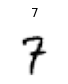

In [ ]:
ax = show_at(train_ds, 3, cmap="Greys", figsize=(1,1))

In [ ]:
assert ax.title.get_text() in ('3','7')
test_fig_exists(ax)

## ToTensor -

In [ ]:
#|export
class ToTensor(Transform):
    "Convert item to appropriate tensor class"
    order = 5

## IntToFloatTensor -

In [ ]:
#|export
class IntToFloatTensor(DisplayedTransform):
    "Transform image to float tensor, optionally dividing by 255 (e.g. for images)."
    order = 10 #Need to run after PIL transforms on the GPU
    def __init__(self, div=255., div_mask=1): store_attr()
    def encodes(self, o:TensorImage): return o.float().div_(self.div)
    def encodes(self, o:TensorMask ): return o.long() // self.div_mask
    def decodes(self, o:TensorImage): return ((o.clamp(0., 1.) * self.div).long()) if self.div else o

In [ ]:
t = (TensorImage(tensor(1)),tensor(2).long(),TensorMask(tensor(3)))
tfm = IntToFloatTensor()
ft = tfm(t)
test_eq(ft, [1./255, 2, 3])
test_eq(type(ft[0]), TensorImage)
test_eq(type(ft[2]), TensorMask)
test_eq(ft[0].type(),'torch.FloatTensor')
test_eq(ft[1].type(),'torch.LongTensor')
test_eq(ft[2].type(),'torch.LongTensor')

/home/hiromi/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


## Normalization -

In [ ]:
#|export
def broadcast_vec(dim, ndim, *t, cuda=True):
    "Make a vector broadcastable over `dim` (out of `ndim` total) by prepending and appending unit axes"
    v = [1]*ndim
    v[dim] = -1
    f = to_device if cuda else noop
    return [f(tensor(o).view(*v)) for o in t]

In [ ]:
#|export
@docs
class Normalize(DisplayedTransform):
    "Normalize/denorm batch of `TensorImage`"
    parameters,order = L('mean', 'std'),99
    def __init__(self, mean=None, std=None, axes=(0,2,3)): store_attr()

    @classmethod
    def from_stats(cls, mean, std, dim=1, ndim=4, cuda=True): return cls(*broadcast_vec(dim, ndim, mean, std, cuda=cuda))

    def setups(self, dl:DataLoader):
        if self.mean is None or self.std is None:
            x,*_ = dl.one_batch()
            self.mean,self.std = x.mean(self.axes, keepdim=True),x.std(self.axes, keepdim=True)+1e-7

    def encodes(self, x:TensorImage): return (x-self.mean) / self.std
    def decodes(self, x:TensorImage):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

    _docs=dict(encodes="Normalize batch", decodes="Denormalize batch")

In [ ]:
mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(mean,std)]
tdl = TfmdDL(train_ds, after_batch=batch_tfms, bs=4, device=default_device())

In [ ]:
x,y  = tdl.one_batch()
xd,yd = tdl.decode((x,y))

test_eq(x.type(), 'torch.cuda.FloatTensor' if default_device().type=='cuda' else 'torch.FloatTensor')
test_eq(xd.type(), 'torch.LongTensor')
test_eq(type(x), TensorImage)
test_eq(type(y), TensorCategory)
assert x.mean()<0.0
assert x.std()>0.5
assert 0<xd.float().mean()/255.<1
assert 0<xd.float().std()/255.<0.5

In [ ]:
#|hide
nrm = Normalize()
batch_tfms = [IntToFloatTensor(), nrm]
tdl = TfmdDL(train_ds, after_batch=batch_tfms, bs=4)
x,y  = tdl.one_batch()
test_close(x.mean(), 0.0, 1e-4)
assert x.std()>0.9, x.std()

In [ ]:
#Just for visuals
from fastai.vision.core import *

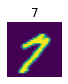

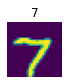

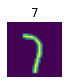

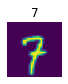

In [ ]:
tdl.show_batch((x,y))

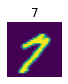

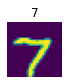

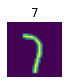

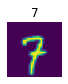

In [ ]:
#|hide
x,y = cast(x,Tensor),cast(y,Tensor) #Lose type of tensors (to emulate predictions)
test_ne(type(x), TensorImage)
tdl.show_batch((x,y), figsize=(1,1)) #Check that types are put back by dl.

## Export -

In [ ]:
#|hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 